In [31]:
!pip install torch torchvision

In [32]:
!pip install pretrainedmodels

In [33]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
matplotlib.style.use('ggplot')

<h2 style="color:black">Function to Clean the Data</h2>

In [34]:
def clean_data(df):
    """
    this functions removes those rows from the DataFrame for which there are
    no images in the dataset
    """
    drop_indices = []
    print('[INFO]: Checking if all images are present')
    for index, image_id in tqdm(df.iterrows()):
        if not os.path.exists(f"C:\\Users\\HP\\Desktop\\Mahidi\\FYP\\Datasets\\Fashion Product Images\\images\\{image_id.id}.jpg"):
            drop_indices.append(index)
    print(f"[INFO]: Dropping indices: {drop_indices}")
    df.drop(df.index[drop_indices], inplace=True)
    return df

<h2 style="color:black">Function to Save the Model</h2>

In [35]:
# save the trained model to disk
def save_model(epochs, model, optimizer, criterion):
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'C:\\Users\\HP\\Desktop\\Mahidi\\FYP\\My Work\\Fashion Product Caption Generator\\Fashion Category Extractor\\category_extraction_model.pth')

<h2 style="color:black">Function to Save the Loss Plots</h2>

In [36]:
# save the train and validation loss plots to disk
def save_loss_plot(train_loss, val_loss):
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(val_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('C:\\Users\\HP\\Desktop\\Mahidi\\FYP\\My Work\\Fashion Product Caption Generator\\Fashion Category Extractor\\loss.jpg')
    plt.show()

<h2 style="color:black">Preparing the Label Dictionaries</h2>

In [37]:
import pandas as pd
import joblib

<h3 style="color:black">Function to Map the Categories to Numbers and Save Them</h3>

In [38]:
def save_label_dicts(df):
    # remove rows from the DataFrame which do not have corresponding images
    df = clean_data(df)
    # we will use the 'gender' and 'baseColour' labels
    # mapping 'gender' to numerical values
    cat_list_gender = df['gender'].unique()
    # 5 unique categories for gender
    num_list_gender = {cat:i for i, cat in enumerate(cat_list_gender)}
    # mapping 'baseColour' to numerical values
    cat_list_colour = df['baseColour'].unique()
    # 15 unique categories for 'baseColour'
    num_list_colour = {cat:i for i, cat in enumerate(cat_list_colour)}
    joblib.dump(num_list_gender, 'C:\\Users\\HP\\Desktop\\Mahidi\\FYP\\My Work\\Fashion Product Caption Generator\\Fashion Category Extractor\\num_listGender.pkl')
    joblib.dump(num_list_colour, 'C:\\Users\\HP\\Desktop\\Mahidi\\FYP\\My Work\\Fashion Product Caption Generator\\Fashion Category Extractor\\num_listColour.pkl')
df = pd.read_csv('C:\\Users\\HP\\Desktop\\Mahidi\\FYP\\Datasets\\Fashion Product Images\\styles.csv', usecols=[0, 1, 2, 3, 4, 4, 5, 6, 9])
save_label_dicts(df)

[INFO]: Checking if all images are present


44446it [00:21, 2113.07it/s]

[INFO]: Dropping indices: [6697, 16207, 32324, 36399, 40022]


In [39]:
# # Remove rows with missing values in the 'baseColour' column
# df = df.dropna(subset=['baseColour'])

# # Print the updated dataframe
# print(df.dropna(subset=['baseColour']))
missing_rows = df[df['baseColour'].isna()]
print(missing_rows)

Empty DataFrame
Columns: [id, gender, masterCategory, subCategory, articleType, baseColour, season, productDisplayName]
Index: []


<h2 style="color:black">Preparing the Dataset</h2>

In [40]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [41]:
from torch.utils.data import Dataset
import torch
import joblib
import math
import cv2
import torchvision.transforms as transforms

<h2 style="color:black">Split the DataFrame into Training and Validation Set</h2>

In [42]:
def train_val_split(df):
    # remove rows from the DataFrame which do not have corresponding images
    df = clean_data(df)
    # shuffle the dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    # 90% for training and 10% for validation
    num_train_samples = math.floor(len(df) * 0.90)
    num_val_samples = math.floor(len(df) * 0.10)
    train_df = df[:num_train_samples].reset_index(drop=True)
    val_df = df[-num_val_samples:].reset_index(drop=True)
    return train_df, val_df

In [43]:
class FashionDataset(Dataset):
    def __init__(self, df, is_train=True):
        self.df = df
        self.num_list_gender = joblib.load('C:\\Users\\HP\\Desktop\\Mahidi\\FYP\\My Work\\Fashion Product Caption Generator\\Fashion Category Extractor\\num_listGender.pkl')
        self.num_list_colour = joblib.load('C:\\Users\\HP\\Desktop\\Mahidi\\FYP\\My Work\\Fashion Product Caption Generator\\Fashion Category Extractor\\num_listColour.pkl')
        
        self.is_train = is_train
        # the training transforms and augmentations
        if self.is_train:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.ToTensor(), 
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        # the validation transforms
        if not self.is_train:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        image = cv2.imread(f"C:\\Users\\HP\\Desktop\\Mahidi\\FYP\\Datasets\\Fashion Product Images\\images\\{self.df['id'][index]}.jpg")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        cat_gender = self.df['gender'][index]
        label_gender = self.num_list_gender[cat_gender]
        cat_colour = self.df['baseColour'][index]
        label_colour = self.num_list_colour[cat_colour]
        # image to float32 tensor
        image = torch.tensor(image, dtype=torch.float32)
        # labels to long tensors
        label_gender = torch.tensor(label_gender, dtype=torch.long)
        label_colour = torch.tensor(label_colour, dtype=torch.long)
        return {
            'image': image,
            'gender': label_gender,
            'colour': label_colour
        }

<h2 style="color:black">The Loss Function</h2>
This is a custom function for the loss function. This is because we have two different labels for which we will have two different loss values in each iteration while training. Therefore, we will need to average over the two loss values.

In [44]:
import torch.nn as nn
# custom loss function for multi-head multi-category classification
def loss_fn(outputs, targets):
    o1, o2 = outputs
    t1, t2 = targets
    l1 = nn.CrossEntropyLoss()(o1, t1)
    l2 = nn.CrossEntropyLoss()(o2, t2)
    return (l1 + l2) / 2

<h2 style="color:black">The Deep Learning Model</h2>

In [45]:
import torch.nn as nn
import torch.nn.functional as F
import pretrainedmodels

In [46]:
class MultiHeadResNet50(nn.Module):
    def __init__(self, pretrained, requires_grad):
        super(MultiHeadResNet50, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained=None)
        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
            print('Training intermediate layer parameters...')
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False
            print('Freezing intermediate layer parameters...')
        # change the final layers according to the number of categories
        self.l0 = nn.Linear(2048, 5) # for gender
        self.l1 = nn.Linear(2048, 48) # for baseColour
    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        l0 = self.l0(x)
        l1 = self.l1(x)
        return l0, l1

<h2 style="color:black">Training</h2>

In [47]:
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

In [48]:
# define the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = MultiHeadResNet50(pretrained=True, requires_grad=False).to(device)
# learning parameters
lr = 0.001
optimizer = optim.Adam(params=model.parameters(), lr=lr)
criterion = loss_fn
batch_size = 32
epochs = 20

C:\Users\HP\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Freezing intermediate layer parameters...


<h2 style="color:black">Preparing the Data Loaders</h2>

In [49]:
df = pd.read_csv('C:\\Users\\HP\\Desktop\\Mahidi\\FYP\\Datasets\\Fashion Product Images\\styles.csv', usecols=[0, 1, 2, 3, 4, 4, 5, 6, 9])
train_data, val_data = train_val_split(df)
print(f"[INFO]: Number of training sampels: {len(train_data)}")
print(f"[INFO]: Number of validation sampels: {len(val_data)}")
# training and validation dataset
train_dataset = FashionDataset(train_data, is_train=True)
val_dataset = FashionDataset(val_data, is_train=False)
# training and validation data loader
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

[INFO]: Checking if all images are present


44446it [00:15, 2935.67it/s]


[INFO]: Dropping indices: [6697, 16207, 32324, 36399, 40022]
[INFO]: Number of training sampels: 39996
[INFO]: Number of validation sampels: 4444


<h3 style="color:black">The Training Function</h3>

In [50]:
# training function
def train(model, dataloader, optimizer, loss_fn, dataset, device):
    model.train()
    counter = 0
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        
        # extract the features and labels
        image = data['image'].to(device)
        gender = data['gender'].to(device)
        colour = data['colour'].to(device)
        
        # zero-out the optimizer gradients
        optimizer.zero_grad()
        
        outputs = model(image)
        targets = (gender, colour)
        loss = loss_fn(outputs, targets)
        train_running_loss += loss.item()
        
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        
    train_loss = train_running_loss / counter
    return train_loss

<h3 style="color:black">The Validation Function</h3>

In [51]:
# validation function
def validate(model, dataloader, loss_fn, dataset, device):
    model.eval()
    counter = 0
    val_running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        
        # extract the features and labels
        image = data['image'].to(device)
        gender = data['gender'].to(device)
        colour = data['colour'].to(device)
        
        outputs = model(image)
        targets = (gender, colour)
        loss = loss_fn(outputs, targets)
        val_running_loss += loss.item()
        
    val_loss = val_running_loss / counter
    return val_loss

<h3 style="color:black">The Training Loop</h3>

Epoch 1 of 20


  0%|          | 0/1249 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_23024\392201997.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
1250it [59:02,  2.83s/it]                          
139it [06:14,  2.69s/it]                         


Train Loss: 1.2397
Validation Loss: 1.0512
Epoch 2 of 20


1250it [59:18,  2.85s/it]                          
139it [06:12,  2.68s/it]                         


Train Loss: 1.0897
Validation Loss: 1.0160
Epoch 3 of 20


1250it [58:46,  2.82s/it]                          
139it [06:14,  2.70s/it]                         


Train Loss: 1.0521
Validation Loss: 1.0178
Epoch 4 of 20


1250it [1:03:52,  3.07s/it]                          
139it [06:15,  2.70s/it]                         


Train Loss: 1.0337
Validation Loss: 1.0158
Epoch 5 of 20


1250it [58:17,  2.80s/it]                          
139it [06:10,  2.67s/it]                         


Train Loss: 1.0171
Validation Loss: 0.9893
Epoch 6 of 20


1250it [1:00:01,  2.88s/it]                        
139it [06:20,  2.74s/it]                         


Train Loss: 1.0023
Validation Loss: 0.9813
Epoch 7 of 20


1250it [1:19:47,  3.83s/it]                          
139it [08:23,  3.62s/it]                         


Train Loss: 0.9847
Validation Loss: 0.9588
Epoch 8 of 20


1250it [1:20:32,  3.87s/it]                          
139it [08:31,  3.68s/it]                         


Train Loss: 0.9801
Validation Loss: 0.9879
Epoch 9 of 20


1250it [1:39:11,  4.76s/it]                            
139it [06:11,  2.67s/it]                         


Train Loss: 0.9678
Validation Loss: 0.9378
Epoch 10 of 20


1250it [58:28,  2.81s/it]                          
139it [06:13,  2.69s/it]                         


Train Loss: 0.9643
Validation Loss: 0.9573
Epoch 11 of 20


1250it [1:01:26,  2.95s/it]                          
139it [06:19,  2.73s/it]                         


Train Loss: 0.9557
Validation Loss: 0.9657
Epoch 12 of 20


1250it [58:51,  2.83s/it]                          
139it [06:16,  2.71s/it]                         


Train Loss: 0.9451
Validation Loss: 0.9549
Epoch 13 of 20


1250it [58:36,  2.81s/it]                          
139it [06:17,  2.72s/it]                         


Train Loss: 0.9396
Validation Loss: 0.9748
Epoch 14 of 20


1250it [1:02:23,  2.99s/it]                          
139it [06:13,  2.69s/it]                         


Train Loss: 0.9363
Validation Loss: 0.9491
Epoch 15 of 20


1250it [59:18,  2.85s/it]                          
139it [06:08,  2.65s/it]                         


Train Loss: 0.9290
Validation Loss: 0.9290
Epoch 16 of 20


1250it [59:10,  2.84s/it]                          
139it [06:30,  2.81s/it]                         


Train Loss: 0.9253
Validation Loss: 0.9566
Epoch 17 of 20


1250it [1:14:51,  3.59s/it]                          
139it [08:35,  3.71s/it]                         


Train Loss: 0.9183
Validation Loss: 0.9432
Epoch 18 of 20


1250it [1:13:27,  3.53s/it]                          
139it [06:12,  2.68s/it]                         


Train Loss: 0.9175
Validation Loss: 0.9797
Epoch 19 of 20


1250it [59:53,  2.88s/it]                          
139it [06:37,  2.86s/it]                         


Train Loss: 0.9134
Validation Loss: 0.9950
Epoch 20 of 20


1250it [1:00:22,  2.90s/it]                          
139it [06:20,  2.74s/it]                         


Train Loss: 0.9121
Validation Loss: 0.9557


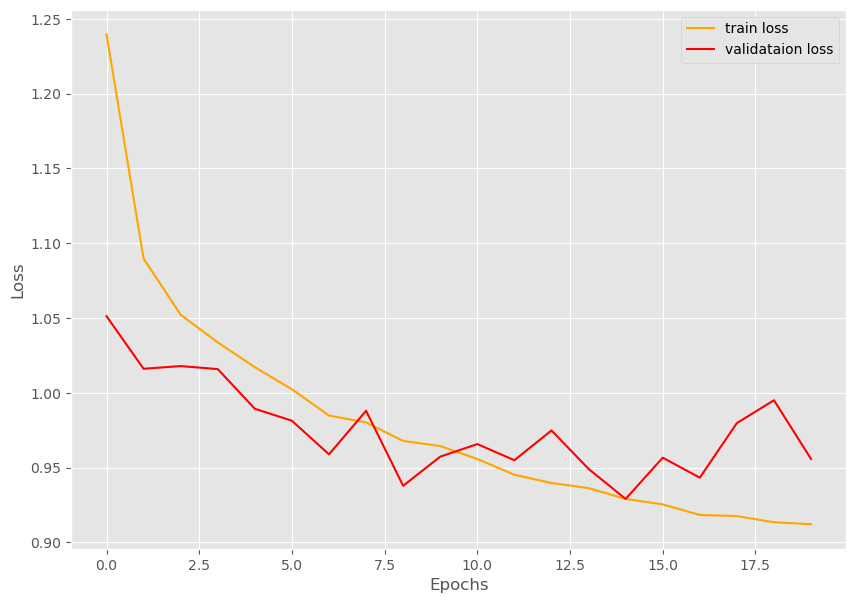

In [22]:
# start the training
train_loss, val_loss = [], []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_dataloader, optimizer, loss_fn, train_dataset, device
    )
    val_epoch_loss = validate(
        model, val_dataloader, loss_fn, val_dataset, device
    )
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Validation Loss: {val_epoch_loss:.4f}")

# save the model to disk
save_model(epochs, model, optimizer, criterion)

# save the training and validation loss plot to disk
save_loss_plot(train_loss, val_loss)

In [26]:
import torch
import cv2
import torchvision.transforms as transforms
import numpy as np
import joblib

# # Import the MultiHeadResNet50 class from the uploaded .ipynb file
# %run '/content/gdrive/MyDrive/Colab Notebooks/Train_Fashion_Category_Extractor.ipynb'
# from Train_Fashion_Category_Extractor import MultiHeadResNet50


# define the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MultiHeadResNet50(pretrained=False, requires_grad=False)
checkpoint = torch.load('C:\\Users\\HP\\Desktop\\Mahidi\\FYP\\My Work\\Fashion Product Caption Generator\\Fashion Category Extractor\\category_extraction_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


C:\Users\HP\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Freezing intermediate layer parameters...


In [67]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for batch in val_dataloader:
        images = batch['image']  # Extract the images from the batch
        predicted_outputs = model(images)  # Pass the images through the model for prediction


C:\Users\HP\AppData\Local\Temp\ipykernel_24916\392201997.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


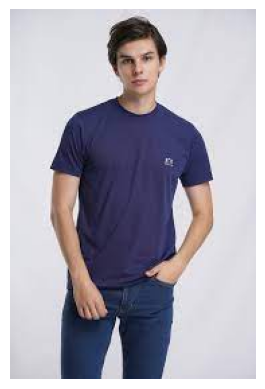

Men Navy Blue


In [30]:
# replace with the path to your input image
input_image_path = "C:\\Users\\HP\\Desktop\\Mahidi\\Pictures\\12.jpg"
# read an image
image = cv2.imread(input_image_path)
# keep a copy of the original image for OpenCV functions
orig_image = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# apply image transforms
image = transform(image)
# add batch dimension
image = image.unsqueeze(0).to(device)
# forward pass the image through the model
outputs = model(image)
# extract the two output
output1, output2 = outputs
# get the index positions of the highest label score
out_label_1 = np.argmax(output1.detach().cpu())
out_label_2 = np.argmax(output2.detach().cpu())

import matplotlib.pyplot as plt

# load the label dictionaries
num_list_gender = joblib.load('C:\\Users\\HP\\Desktop\\Mahidi\\FYP\\My Work\\Fashion Product Caption Generator\\Fashion Category Extractor\\num_listGender.pkl')
num_list_colour = joblib.load('C:\\Users\\HP\\Desktop\\Mahidi\\FYP\\My Work\\Fashion Product Caption Generator\\Fashion Category Extractor\\num_listColour.pkl')

# get the keys and values of each label dictionary
gender_keys = list(num_list_gender.keys())
gender_values = list(num_list_gender.values())
colour_keys = list(num_list_colour.keys())
colour_values = list(num_list_colour.values())
final_labels = []

# append the labels by mapping the index position to the values 
final_labels.append(gender_keys[gender_values.index(out_label_1)])
final_labels.append(colour_keys[colour_values.index(out_label_2)])

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Optional: Remove the axis labels
plt.show()

print(final_labels[0], final_labels[1])